## Objective: Sales forecating 

### Step 1. Explore contents of aggregated training data
Contains 5 event types: "sold", "set to sale", "donation", "waste", "transfer"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from src.data_loader import load_data, aggregate_all
from src.data_features import add_weekday_feature, remove_weekends, handle_holidays

In [3]:
config_path = "../config.yaml"
with open(config_path) as f:
        config = yaml.safe_load(f)

train_pl = load_data("../"+config["dataset_path"])

agg_pl = aggregate_all(train_pl)
agg_pl.head()


DATE,TOTAL_TRANSFER,TOTAL_SET TO SALE,TOTAL_SOLD,TOTAL_DONATION,TOTAL_WASTE
date,i64,i64,i64,i64,i64
2025-01-02,null,916,null,null,null
2025-01-03,null,762,-508,null,null
2025-01-04,null,null,-221,null,null
2025-01-05,null,10752,-267,null,null
2025-01-06,null,3404,-3907,-196,-215


In [4]:
agg_pl.describe()

statistic,DATE,TOTAL_TRANSFER,TOTAL_SET TO SALE,TOTAL_SOLD,TOTAL_DONATION,TOTAL_WASTE
str,str,f64,f64,f64,f64,f64
"""count""","""226""",26.0,191.0,225.0,183.0,219.0
"""null_count""","""0""",200.0,35.0,1.0,43.0,7.0
"""mean""","""2025-04-24 12:00:00""",-26.192308,4402.659686,-2824.124444,-70.863388,-550.570776
"""std""",null,36.923726,3415.275505,1745.79402,117.032812,695.269652
"""min""","""2025-01-02""",-140.0,396.0,-5157.0,-691.0,-2291.0
"""25%""","""2025-02-27""",-31.0,2118.0,-4187.0,-93.0,-1006.0
"""50%""","""2025-04-25""",-7.0,3477.0,-3689.0,-14.0,-209.0
"""75%""","""2025-06-20""",-3.0,4965.0,-413.0,-5.0,-44.0
"""max""","""2025-08-15""",-1.0,12701.0,-204.0,-1.0,-1.0


In [5]:
date_col = "DATE"
cols = ['TOTAL_SET TO SALE', 'TOTAL_WASTE', 'TOTAL_SOLD', "TOTAL_DONATION"]

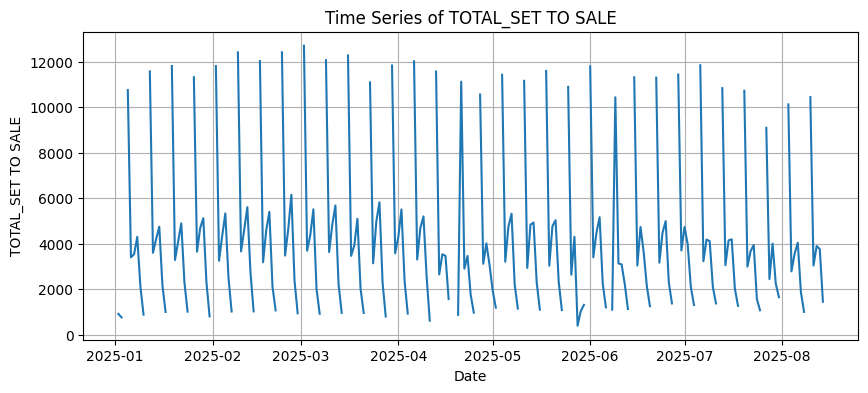

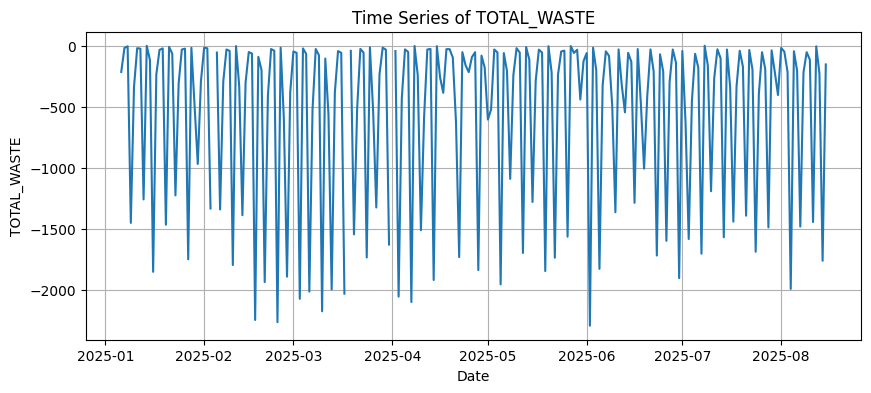

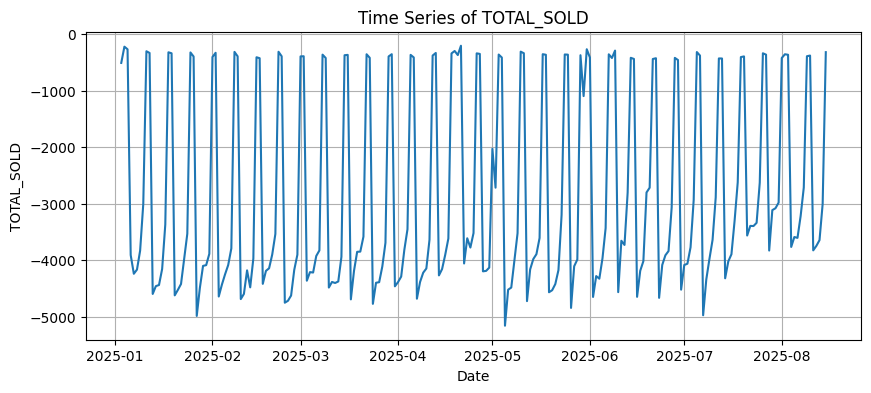

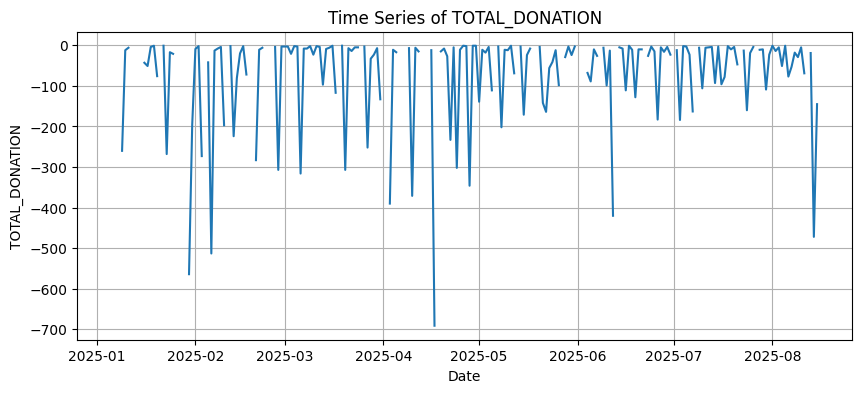

In [6]:
for col in cols:
    plt.figure(figsize=(10, 4))
    plt.plot(agg_pl[date_col], agg_pl[col])
    plt.title(f'Time Series of {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid()
    plt.show()

#### Insights & Questions:
1. Data covers Jan 02 - Aug 15, 2025
2. Transfers (whatever they are) - pretty rare. Will ignore for now
3. Clear periodicity in data. Likely based on day of week, explore further.
3. Donations - have a more sporadic frequency of spikes, vs others. Some kind of charitable events? Will ignore for now
2. Set to Sale - only positive inventory change. I assumed it means "discount". Does it mean restocking? Gaps in data seem to also indicate restocking - weekends?
3. Average waste 550, average sold 2800 --> approx 20% waste. Set as first performance KPI?


In [7]:
approx_waste_ratio = 550/2800

In [8]:
date_col = "DATE"
target_cols = ["TOTAL_SOLD", "TOTAL_WASTE"]

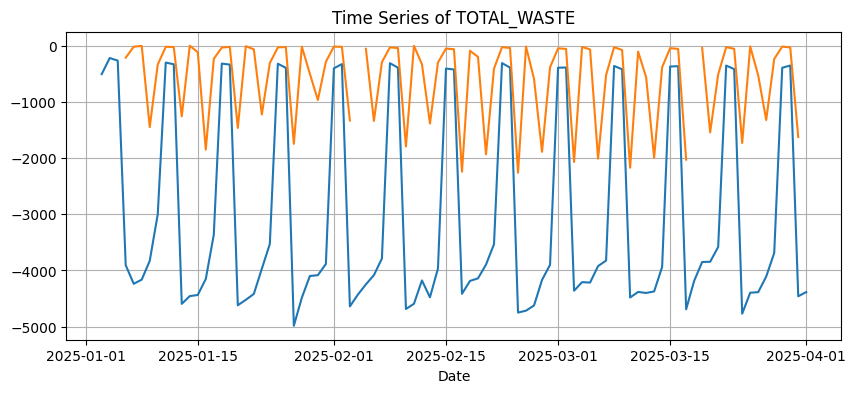

In [9]:
time_limit = 90
plt.figure(figsize=(10, 4))
for col in target_cols:
    plt.plot(agg_pl[date_col][:time_limit], agg_pl[col][:time_limit], label=col)
    plt.title(f'Time Series of {col}')
    plt.xlabel('Date')
plt.grid()
plt.show()

In [10]:
agg_pl = add_weekday_feature(agg_pl, date_col=date_col)

## Waste and Sold by Weekday (Mean Values) ##
waste_by_weekday = agg_pl.group_by("WEEKDAY").agg(pl.col("TOTAL_WASTE").mean().alias("MEAN_WASTE")).sort("WEEKDAY")
sold_by_weekday = agg_pl.group_by("WEEKDAY").agg(pl.col("TOTAL_SOLD").min().alias("MEAN_SOLD")).sort("WEEKDAY")

waste_by_weekday.head(7), sold_by_weekday.head(7)


(shape: (7, 2)
 ┌─────────┬─────────────┐
 │ WEEKDAY ┆ MEAN_WASTE  │
 │ ---     ┆ ---         │
 │ i64     ┆ f64         │
 ╞═════════╪═════════════╡
 │ 0       ┆ -1648.4375  │
 │ 1       ┆ -134.137931 │
 │ 2       ┆ -230.09375  │
 │ 3       ┆ -1314.625   │
 │ 4       ┆ -332.25     │
 │ 5       ┆ -41.806452  │
 │ 6       ┆ -83.096774  │
 └─────────┴─────────────┘,
 shape: (7, 2)
 ┌─────────┬───────────┐
 │ WEEKDAY ┆ MEAN_SOLD │
 │ ---     ┆ ---       │
 │ i64     ┆ i64       │
 ╞═════════╪═══════════╡
 │ 0       ┆ -5157     │
 │ 1       ┆ -4716     │
 │ 2       ┆ -4623     │
 │ 3       ┆ -4478     │
 │ 4       ┆ -3966     │
 │ 5       ┆ -439      │
 │ 6       ┆ -457      │
 └─────────┴───────────┘)

### Clear pattern by weekday - remove weekends to inspect better

In [11]:
agg_pl = remove_weekends(agg_pl, target="WEEKDAY")

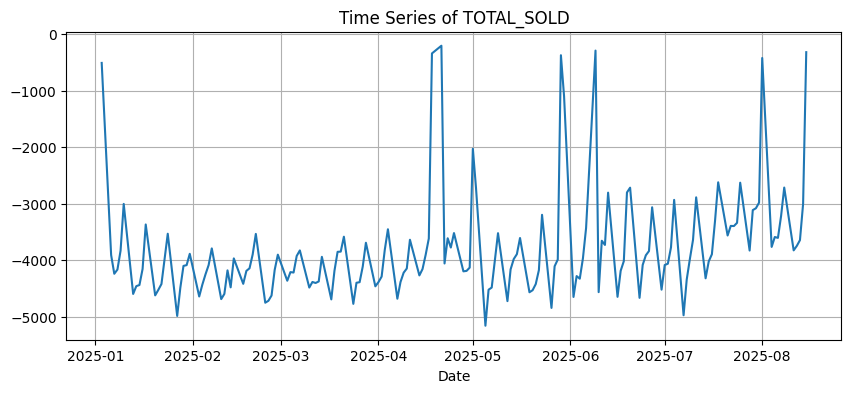

In [12]:
time_limit = 230
col = "TOTAL_SOLD"
plt.figure(figsize=(10, 4))
plt.plot(agg_pl[date_col][:time_limit], agg_pl[col][:time_limit], label=col)
plt.title(f'Time Series of {col}')
plt.xlabel('Date')
plt.grid()
plt.show()

In [13]:
### Outliers - holidays?
threshold = -2100
mask = agg_pl[col] > threshold
agg_pl.filter(mask)

DATE,TOTAL_TRANSFER,TOTAL_SET TO SALE,TOTAL_SOLD,TOTAL_DONATION,TOTAL_WASTE,WEEKDAY
date,i64,i64,i64,i64,i64,i64
2025-01-03,null,762,-508,null,null,4
2025-04-18,null,null,-340,null,-29,4
2025-04-21,null,11121,-204,-27,-626,0
2025-05-01,null,1943,-2027,-139,-605,3
2025-05-29,null,1036,-372,-3,-34,3
2025-05-30,null,1309,-1095,-24,-441,4
2025-06-09,null,10434,-290,-6,-489,0
2025-08-01,null,null,-421,-1,-19,4
2025-08-15,-2,null,-318,-145,-154,4


### Insights & Questions part 2

1. Clear weekday pattern - sales decrease steadily Monday - Friday and drop over weekend (interestingly not 0!)
2. Holidays are outliers - we don't have enough data to learn them, so they will only confuse the model. Treat as outliers?
3. Waste peaks Mondays & Thursdays - is this artifact of collection times? or based on periodic preparation? No time to explore further.

In [14]:
agg_pl = handle_holidays(agg_pl, target="TOTAL_SOLD", handle="impute")

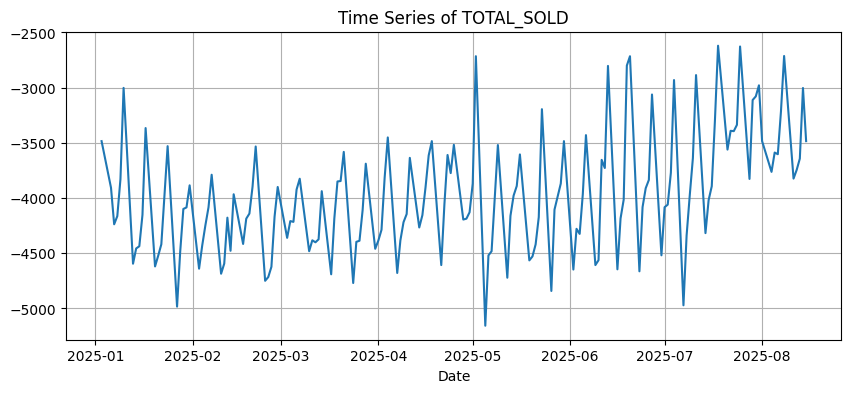

In [15]:
time_limit = 230
col = "TOTAL_SOLD"
plt.figure(figsize=(10, 4))
plt.plot(agg_pl[date_col][:time_limit], agg_pl[col][:time_limit], label=col)
plt.title(f'Time Series of {col}')
plt.xlabel('Date')
plt.grid()
plt.show()

#### Check for missing days: seems no further impute needed

In [16]:
train_pl = load_data("../"+config["dataset_path"])
agg_pl = aggregate_all(train_pl)

agg_pl = agg_pl.drop_nulls(col)
agg_pl[date_col].min()-agg_pl[date_col].max(),len(agg_pl)

(datetime.timedelta(days=-224), 225)